# Import Libraries

In [1]:
import re
import os
import io
import spacy
import string
import numpy as np
import pandas as pd

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')


# Read and Prepare Dataset

In [2]:
dataset = pd.read_csv("processedcovidvaccinereact.csv", index_col=0)
dataset.shape

(126250, 7)

In [3]:
dataset = dataset.dropna() # drop null values
dataset.shape

(125829, 7)

In [4]:
dataset.head(5)

,TweetDate,TweetText,CleanedTweet,TweetAuthor,TweetLocation,AllHashtags,Country
0,2021-03-17 23:59:34,The only way #COVID19 can mutate with variants...,onli way mutat variant viru replic host peopl ...,kemsunde,Unknown,"['COVID19', 'CovidVaccine', 'GetTheFactsGetThe...",Unknown
1,2021-03-17 23:59:20,I've now officially had my 1st dose of the #Co...,ive offici dose covidvaccin definit worth driv...,ManeckiN,The Wild Western Wastes,"['CovidVaccine', 'COVID19', 'PfizerVaccine', '...",Unknown
2,2021-03-17 23:58:31,@hendopolis Imagine if the #Brexit referendum ...,hendopoli imagin brexit referendum held secret...,raymasseytweets,England,"['Brexit', 'EU', 'TrueColours', 'Impfstoff', '...",United Kingdom
3,2021-03-17 23:58:03,@EICostheta @RicBarraArch1 @insiders Yep. The ...,eicostheta insid yep liarsnparasit veri narrow...,MikeFitzAU,Mudjimba,"['LiarsNParasites', 'CovidVaccine']",Australia
4,2021-03-17 23:57:37,This sounds like an important topic for @NickS...,thi sound like import topic nicksawyermd tnich...,stephjantzen,Greater Sacramento,"['FiresideChat', 'CovidVaccine']",Brazil


In [5]:
text_data = dataset["CleanedTweet"]  # select cleaned tweets column
#text_data = text_data[:100]

In [6]:
text_data =  [text.split() for text in text_data]  # tokenize dataset

### Make Bigrams for LDA Model

In [7]:
# Build the bigram models
bigram = gensim.models.Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

text_data = [bigram_mod[doc] for doc in text_data]

# Build Dictionary

In [8]:
# make dictionary of complete corpus
dictionary_LDA = corpora.Dictionary(text_data)
# filter tokens below frequency of 3 words
dictionary_LDA.filter_extremes(no_below=3)
# index to words 
corpus = [dictionary_LDA.doc2bow(tok) for tok in text_data]

# Build LDA Model
# Compute Coherence and Preplexity
# Choose optimal number of topics

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    topics_list = [10, 15, 20]
    coherence_values = []
    perplexity_val = []
    model_list = []
    for num_topics in topics_list:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4, alpha=0.05, eta=[0.01]*len(dictionary_LDA.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_val.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_val

# Train LDA Model

In [10]:
# Can take a long time to run.
model_list, coherence_values, perplexity_val = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus, texts=text_data, start=2, limit=40, step=6)

# Plot Coherence Scores

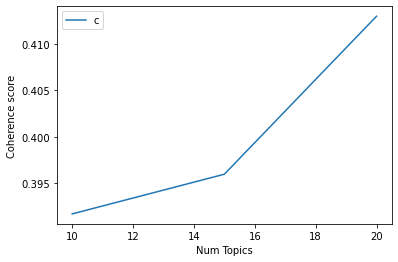

In [11]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [10,15,20]
plt.plot(topics_list, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Plot Perplexity Scores

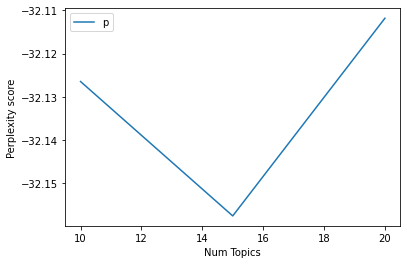

In [12]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [10,15,20]
plt.plot(topics_list, perplexity_val)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

### Display Results

In [13]:
# Print the coherence scores
topics_list = [10,15,20]
for m, cv, pr in zip(topics_list, coherence_values, perplexity_val):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " has Perplexity of", round(pr, 4))

Num Topics = 10  has Coherence Value of 0.3917  has Perplexity of -32.1264
Num Topics = 15  has Coherence Value of 0.396  has Perplexity of -32.1575
Num Topics = 20  has Coherence Value of 0.413  has Perplexity of -32.1118


## Train Model with Best number of topics

In [14]:
best_topic_number = 15
best_model = models.LdaModel(corpus, num_topics=best_topic_number, id2word=dictionary_LDA, passes=4, alpha=0.05, eta=[0.01]*len(dictionary_LDA.keys()))
        

In [15]:
coherencemodel = CoherenceModel(model=best_model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
coherence_score = coherencemodel.get_coherence()
perplexity_score = best_model.log_perplexity(corpus)
print("Num Topics =", best_topic_number, " has Coherence Value of", round(coherence_score, 4), " has Perplexity of", round(perplexity_score, 4))
        

Num Topics = 15  has Coherence Value of 0.4332  has Perplexity of -32.117


In [16]:
# display all topics with weight of all keywords
for i,topic in best_model.show_topics(formatted=True, num_topics=best_topic_number, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.036*"covidvaccin" + 0.030*"uk" + 0.027*"thi" + 0.025*"vaccin" + 0.022*"whi" + 0.020*"say" + 0.018*"peopl" + 0.017*"wa" + 0.016*"think" + 0.016*"immun" + 0.015*"eu" + 0.014*"like" + 0.014*"come" + 0.012*"onli" + 0.012*"work" + 0.012*"covid" + 0.011*"one" + 0.011*"could" + 0.010*"want" + 0.010*"respons"

1: 0.121*"ha" + 0.090*"covidvaccin" + 0.066*"vaccin" + 0.035*"countri" + 0.033*"india" + 0.027*"million" + 0.027*"new" + 0.026*"administ" + 0.022*"case" + 0.020*"report" + 0.017*"rollout" + 0.017*"given" + 0.016*"export" + 0.015*"state" + 0.015*"total" + 0.013*"ani" + 0.012*"suppli" + 0.012*"popul" + 0.012*"ontario" + 0.010*"develop"

2: 0.058*"vaccin" + 0.054*"provid" + 0.048*"covidvaccin" + 0.026*"thi" + 0.016*"pakistan" + 0.014*"import" + 0.014*"watch" + 0.013*"clinic" + 0.013*"spread" + 0.012*"public" + 0.011*"health" + 0.011*"visit" + 0.011*"talk" + 0.011*"member" + 0.011*"help" + 0.010*"video" + 0.010*"learn" + 0.010*"mass" + 0.010*"covid" + 0.009*"make"

3: 0.060*"share" + 0.

# Visulaize Topics

In [17]:
import pyLDAvis.gensim
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary=dictionary_LDA, mds='mmds')
vis

C:\Users\hammad\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\hammad\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.102319  0.363284       1        1  12.868764
8     -0.157989  0.151602       2        1   9.393921
0     -0.307505  0.263587       3        1   7.790920
10     0.076066  0.116468       4        1   7.305642
1      0.302778  0.286604       5        1   7.063252
2     -0.028612 -0.088295       6        1   7.018193
14     0.079373 -0.297911       7        1   6.529895
13     0.099642  0.407351       8        1   6.505939
9     -0.216607 -0.251352       9        1   6.155543
11    -0.421544  0.062930      10        1   5.905669
12     0.439222  0.091794      11        1   5.394633
5      0.360977 -0.093004      12        1   5.394631
4     -0.399964 -0.198940      13        1   4.589756
7      0.337059 -0.338404      14        1   4.226837
3     -0.060577 -0.475714      15        1   3.856403, topic_info=       Term           Freq          Total Category  logprob  loglift
124      ha   12785.000000   12785.000000  Default  30.0000  30.0000
78      thi   24792.000000   24792.000000  Default  29.0000  29.0000
87   vaccin  100625.000000  100625.000000  Default  28.0000  28.0000
344    year   10045.000000   10045.000000  Default  27.0000  27.0000
50      amp   16333.000000   16333.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
58    never     542.351079    1165.169251  Topic15  -4.6696   2.4907
934   pleas     745.805290    5108.777794  Topic15  -4.3510   1.3312
87   vaccin    1205.690465  100625.443811  Topic15  -3.8707  -1.1689
82    covid     717.610797   15186.708221  Topic15  -4.3896   0.2032
268     may     566.662999    2033.910807  Topic15  -4.6257   1.9775

[777 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2652      9  1.000030       abov
963       6  0.812460     access
963      12  0.187620     access
1350      7  1.000194    account
2259      6  0.998515     achiev
...     ...       ...        ...
344      10  0.930888       year
436       1  0.999946  yesterday
3164      9  1.000455         yo
897      10  0.998155      young
446      12  0.999850       youv

[1076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 1, 11, 2, 3, 15, 14, 10, 12, 13, 6, 5, 8, 4])

# All Topics Probabilities in each Document

In [18]:
# convert all probability distribution into dataframe (we are doing this to also keep topics having 0 probability)
# In other case topics having 0 probability will be misleading
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [19]:
# find topic probabilities that model assign to all documents
topics = [best_model[corpus[i]] for i in range(len(text_data))]

In [20]:
# make dataframe of all document probability distribution
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=best_topic_number) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [24]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.486326,0.000000,0.224133,0.000000,0.195584,0.000000,0.064569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.076025,0.000000,0.000000,0.000000,0.047201,0.000000,0.194494,0.052041,0.554452,0.000000,0.055998,0.000000,0.000000,0.000000,0.000000
2,0.635860,0.000000,0.000000,0.000000,0.139424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147280
3,0.054621,0.000000,0.000000,0.087824,0.063220,0.000000,0.000000,0.000000,0.052579,0.094030,0.229967,0.000000,0.000000,0.310247,0.092113
4,0.000000,0.000000,0.485657,0.082806,0.083499,0.000000,0.000000,0.000000,0.163585,0.000000,0.000000,0.000000,0.000000,0.000000,0.148084
5,0.000000,0.270094,0.000000,0.000000,0.114131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123397,0.435952,0.000000
6,0.000000,0.129252,0.000000,0.000000,0.000000,0.160256,0.000000,0.000000,0.341873,0.060659,0.000000,0.057901,0.119173,0.061270,0.053517
7,0.000000,0.000000,0.000000,0.000000,0.261487,0.082407,0.000000,0.066898,0.000000,0.000000,0.000000,0.000000,0.000000,0.231745,0.327607
8,0.588360,0.058434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077088,0.000000,0.251930,0.000000,0.000000,0.000000,0.000000
9,0.194515,0.154102,0.000000,0.000000,0.092327,0.000000,0.229134,0.095715,0.000000,0.110577,0.089563,0.000000,0.000000,0.000000,0.000000


# Calculate and Find Keywords in each Document


In [22]:
def format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Per_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4863,"covidvaccin, uk, thi, vaccin, whi, say, peopl,...","[onli, way, mutat, variant, viru, replic, host..."
1,1,8.0,0.5545,"vaccin, get, covidvaccin, go, im, like, peopl,...","[ive, offici, dose, covidvaccin, definit, wort..."
2,2,0.0,0.6359,"covidvaccin, uk, thi, vaccin, whi, say, peopl,...","[hendopoli, imagin, brexit, referendum, held, ..."
3,3,13.0,0.3103,"vaccin, astrazeneca, coronaviru, covidvaccin, ...","[eicostheta, insid, yep, liarsnparasit, veri, ..."
4,4,2.0,0.4856,"vaccin, provid, covidvaccin, thi, pakistan, im...","[thi, sound, like, import, topic, nicksawyermd..."
5,5,13.0,0.4361,"vaccin, astrazeneca, coronaviru, covidvaccin, ...","[studi, show, fdaapprov, vaccin, protect, curr..."
6,6,8.0,0.3419,"vaccin, get, covidvaccin, go, im, like, peopl,...","[updat, back, park, lot, peopl, line, vaccin, ..."
7,7,14.0,0.3276,"thi, take, u, know, vaccin, covidvaccin, plan,...","[german, headlin, angela_merkel, refus, astraz..."
8,8,0.0,0.5884,"covidvaccin, uk, thi, vaccin, whi, say, peopl,...","[mask, ha, slip, eu, savag, aw, vaccin, block,..."
9,9,6.0,0.2291,"vaccin, first, covidvaccin, got, dose, today, ...","[chicagoan, age, older, receiv, first, dose, w..."
